In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as r2
#from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import explained_variance_score as EVS


/data/conda/wqml/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.11.0-CAPI-1.17.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
land_cover = pd.read_csv('results_lcm/upload_to_Oracle.csv')
catchment_descriptors = pd.read_csv('results_cds/upload_to_Oracle.csv')

In [3]:
lcm2015 = land_cover[land_cover['PROPERTY_GROUP']=='lcm2015nrfav2021']
lcm2015

Unnamed: 0.1  Unnamed: 0  STATION    PROPERTY_GROUP  \
121                121          22   303821  lcm2015nrfav2021   
122                122          23   303821  lcm2015nrfav2021   
123                123          24   303821  lcm2015nrfav2021   
124                124          25   303821  lcm2015nrfav2021   
125                125          26   303821  lcm2015nrfav2021   
...                ...         ...      ...               ...   
27884539      27884539          26   160155  lcm2015nrfav2021   
27884540      27884540          27   160155  lcm2015nrfav2021   
27884541      27884541          28   160155  lcm2015nrfav2021   
27884542      27884542          29   160155  lcm2015nrfav2021   
27884543      27884543          30   160155  lcm2015nrfav2021   

                    PROPERTY_ITEM  PROPERTY_VALUE PROPERTY_METHOD  \
121                      Woodland        0.000000       automatic   
122       Arable and Horticulture        0.000000       automatic   
123                     Grassland        1.704545       automatic   
124                     Heath/Bog       98.295455       automatic   
125                   Inland Rock        0.000000       automatic   
...                           ...             ...             ...   
27884539              Inland Rock        0.000000       automatic   
27884540                    Water        0.000000       automatic   
27884541                  Coastal        0.000000       automatic   
27884542                    Urban        3.583735       automatic   
27884543                  Unknown        0.000000       automatic   

          PROPERTY_COMMENT                    TITLE       UNITS  \
121                    NaN                 Woodland  proportion   
122                    NaN  Arable and Horticulture  proportion   
123                    NaN                Grassland  proportion   
124                    NaN                Heath/Bog  proportion   
125                    NaN              Inland Rock  proportion   
...                    ...                      ...         ...   
27884539               NaN              Inland Rock  proportion   
27884540               NaN                    Water  proportion   
27884541               NaN                  Coastal  proportion   
27884542               NaN                    Urban  proportion   
27884543               NaN                  Unknown  proportion   

            SOURCE_VALUE  
121                  1+2  
122                    3  
123            4+5+6+7+8  
124              9+10+11  
125                   12  
...                  ...  
27884539              12  
27884540           13+14  
27884541  15+16+17+18+19  
27884542           20+21  
27884543            9999  

[3911463 rows x 11 columns]

In [4]:
lcm2015_pivoted = lcm2015[['STATION','PROPERTY_ITEM', 'PROPERTY_VALUE']].pivot(index='STATION', columns='PROPERTY_ITEM', values='PROPERTY_VALUE')
lcm2015_pivoted

PROPERTY_ITEM  Arable and Horticulture  Coastal  Grassland   Heath/Bog  \
STATION                                                                  
1                                  0.0      0.0   0.000000   99.497487   
2                                  0.0      0.0   0.000000   95.714286   
3                                  0.0      0.0   0.000000  100.000000   
4                                  0.0      0.0   7.196761   84.667771   
5                                  0.0      0.0   0.000000   89.619377   
...                                ...      ...        ...         ...   
436183                             0.0      0.0   0.000000  100.000000   
436184                             0.0      0.0   0.000000   78.571429   
436185                             0.0      0.0   0.000000   80.000000   
436186                             0.0      0.0   0.000000   41.860465   
436187                             0.0      0.0   0.000000   89.285714   

PROPERTY_ITEM  Inland Rock  Unknown  Urban      Water   Woodland  
STATION                                                           
1                      0.0      0.0    0.0   0.000000   0.502513  
2                      0.0      0.0    0.0   0.000000   4.285714  
3                      0.0      0.0    0.0   0.000000   0.000000  
4                      0.0      0.0    0.0   0.000000   8.135468  
5                      0.0      0.0    0.0   0.000000  10.380623  
...                    ...      ...    ...        ...        ...  
436183                 0.0      0.0    0.0   0.000000   0.000000  
436184                 0.0      0.0    0.0  21.428571   0.000000  
436185                 0.0      0.0    0.0  10.000000  10.000000  
436186                 0.0      0.0    0.0  20.930233  37.209302  
436187                 0.0      0.0    0.0  10.714286   0.000000  

[434607 rows x 9 columns]

In [5]:
catchment_desc_pivoted = catchment_descriptors[['STATION','PROPERTY_ITEM', 'PROPERTY_VALUE']].pivot(index='STATION', columns='PROPERTY_ITEM', values='PROPERTY_VALUE')
catchment_desc_pivoted

PROPERTY_ITEM     CCAR   HGHT   QALT   QASB  QASV      QB19   QBFI  QDPB  \
STATION                                                                    
1               0.4975  229.9    NaN    NaN   NaN  0.257640    NaN   NaN   
2               0.3500  179.0    NaN    NaN   NaN  0.262752    NaN   NaN   
3               0.4975  198.1    NaN    NaN   NaN  0.257997    NaN   NaN   
4              13.5825   35.1  230.0  120.0  0.31  0.262950  0.289  3.84   
5               0.7225  145.3  237.0  105.0  0.80  0.260754  0.286  1.04   
...                ...    ...    ...    ...   ...       ...    ...   ...   
436183          0.3800   61.0    NaN    NaN   NaN  0.291625    NaN   NaN   
436184          0.0350   76.5    NaN    NaN   NaN  0.303625    NaN   NaN   
436185          0.0250   76.5    NaN    NaN   NaN  0.303625    NaN   NaN   
436186          0.1075   77.5    NaN    NaN   NaN  0.303625    NaN   NaN   
436187          0.1400   77.3    NaN    NaN   NaN  0.306966    NaN   NaN   

PROPERTY_ITEM   QDPS  QFAR  ...     Q_D3     Q__C     Q__E     Q__F   RMD1  \
STATION                     ...                                              
1                NaN   NaN  ...      NaN      NaN      NaN      NaN  0.433   
2                NaN   NaN  ...      NaN      NaN      NaN      NaN  0.426   
3                NaN   NaN  ...      NaN      NaN      NaN      NaN  0.426   
4              144.2   1.0  ...  0.38030 -0.01824  0.25242  2.17901  0.444   
5               98.7   1.0  ...  0.37787 -0.01800  0.25193  2.17630  0.444   
...              ...   ...  ...      ...      ...      ...      ...    ...   
436183           NaN   NaN  ...      NaN      NaN      NaN      NaN  0.394   
436184           NaN   NaN  ...      NaN      NaN      NaN      NaN  0.394   
436185           NaN   NaN  ...      NaN      NaN      NaN      NaN  0.453   
436186           NaN   NaN  ...      NaN      NaN      NaN      NaN  0.453   
436187           NaN   NaN  ...      NaN      NaN      NaN      NaN  0.394   

PROPERTY_ITEM   RMD2   RMD3   RM_C   RM_E   RM_F  
STATION                                           
1              0.474  0.385 -0.018  0.252  2.174  
2              0.475  0.377 -0.018  0.251  2.175  
3              0.475  0.377 -0.018  0.251  2.175  
4              0.475  0.390 -0.018  0.252  2.153  
5              0.475  0.390 -0.018  0.252  2.153  
...              ...    ...    ...    ...    ...  
436183         0.401  0.370 -0.022  0.269  2.126  
436184         0.401  0.370 -0.022  0.269  2.126  
436185         0.440  0.377 -0.022  0.269  1.993  
436186         0.440  0.377 -0.022  0.269  1.993  
436187         0.401  0.370 -0.022  0.269  2.126  

[434607 rows x 39 columns]

In [6]:
Site_ID = pd.read_csv('20200215_unique_matched_wq_riv_sites_reduced.csv')

Site_ID
del Site_ID['Unnamed: 0']
SITE_ID_TO_OBJECTID = Site_ID[['site_id','OBJECTID','STRAHLER','SHREVE','HA','easting','northing','geometry']]
SITE_ID_TO_OBJECTID = SITE_ID_TO_OBJECTID.drop_duplicates(subset=['site_id'])
SITE_ID_TO_OBJECTID = SITE_ID_TO_OBJECTID[['site_id','OBJECTID']]
SITE_ID_TO_OBJECTID

site_id  OBJECTID
0         AN-01M02    162499
1         AN-01M04    155987
2         AN-01M05    155814
3         AN-01M07    155684
4         AN-01M08    155999
...            ...       ...
17413  TH-PWYR0015    179583
17414  TH-PWYR0016    179935
17415  TH-PWYR0026    184687
17416  TH-PWYR0041    184687
17417  TH-PWYR0045    179935

[17319 rows x 2 columns]

In [7]:
new_data = SITE_ID_TO_OBJECTID.merge(catchment_desc_pivoted, how='left', left_on='OBJECTID',right_on='STATION')
new_data

site_id  OBJECTID      CCAR   HGHT   QALT   QASB  QASV      QB19  \
0         AN-01M02    162499   15.7250  116.5  143.0  159.0  0.15  0.327609   
1         AN-01M04    155987   43.4825   99.9  138.0  157.0  0.17  0.414471   
2         AN-01M05    155814   89.7800   91.0  133.0  134.0  0.13  0.580306   
3         AN-01M07    155684  148.5050   73.5  125.0  138.0  0.14  0.559701   
4         AN-01M08    155999   25.1675  100.8  138.0  133.0  0.17  0.657254   
...            ...       ...       ...    ...    ...    ...   ...       ...   
17314  TH-PWYR0015    179583  134.1825   24.8  149.0  129.0  0.18  0.838751   
17315  TH-PWYR0016    179935  111.1350   53.2  160.0  125.0  0.20  0.838697   
17316  TH-PWYR0026    184687   28.8400   78.1  173.0  141.0  0.27  0.774202   
17317  TH-PWYR0041    184687   28.8400   78.1  173.0  141.0  0.27  0.774202   
17318  TH-PWYR0045    179935  111.1350   53.2  160.0  125.0  0.20  0.838697   

        QBFI   QDPB  ...     Q_D3     Q__C     Q__E     Q__F   RMD1   RMD2  \
0      0.316   3.74  ...  0.22905 -0.02319  0.29667  2.48055  0.325  0.322   
1      0.410   8.53  ...  0.22938 -0.02323  0.29655  2.48083  0.322  0.336   
2      0.588  11.75  ...  0.23558 -0.02317  0.29648  2.48280  0.318  0.320   
3      0.568  19.97  ...  0.24248 -0.02306  0.29632  2.47416  0.326  0.321   
4      0.677   4.93  ...  0.23878 -0.02331  0.29691  2.48912  0.322  0.303   
...      ...    ...  ...      ...      ...      ...      ...    ...    ...   
17314  0.797  17.06  ...  0.29022 -0.02510  0.30564  2.64464  0.271  0.308   
17315  0.800  11.54  ...  0.29997 -0.02499  0.30575  2.63383  0.292  0.312   
17316  0.727   5.76  ...  0.29202 -0.02481  0.30727  2.63438  0.308  0.276   
17317  0.727   5.76  ...  0.29202 -0.02481  0.30727  2.63438  0.308  0.276   
17318  0.800  11.54  ...  0.29997 -0.02499  0.30575  2.63383  0.292  0.312   

        RMD3   RM_C   RM_E   RM_F  
0      0.229 -0.023  0.297  2.468  
1      0.233 -0.023  0.296  2.469  
2      0.249 -0.023  0.298  2.454  
3      0.270 -0.023  0.297  2.415  
4      0.253 -0.023  0.296  2.482  
...      ...    ...    ...    ...  
17314  0.231 -0.025  0.301  2.698  
17315  0.242 -0.026  0.307  2.678  
17316  0.283 -0.025  0.304  2.668  
17317  0.283 -0.025  0.304  2.668  
17318  0.242 -0.026  0.307  2.678  

[17319 rows x 41 columns]

In [8]:
new_data2 = new_data.merge(lcm2015_pivoted, how='left', left_on='OBJECTID', right_on='STATION')
new_data2

site_id  OBJECTID      CCAR   HGHT   QALT   QASB  QASV      QB19  \
0         AN-01M02    162499   15.7250  116.5  143.0  159.0  0.15  0.327609   
1         AN-01M04    155987   43.4825   99.9  138.0  157.0  0.17  0.414471   
2         AN-01M05    155814   89.7800   91.0  133.0  134.0  0.13  0.580306   
3         AN-01M07    155684  148.5050   73.5  125.0  138.0  0.14  0.559701   
4         AN-01M08    155999   25.1675  100.8  138.0  133.0  0.17  0.657254   
...            ...       ...       ...    ...    ...    ...   ...       ...   
17314  TH-PWYR0015    179583  134.1825   24.8  149.0  129.0  0.18  0.838751   
17315  TH-PWYR0016    179935  111.1350   53.2  160.0  125.0  0.20  0.838697   
17316  TH-PWYR0026    184687   28.8400   78.1  173.0  141.0  0.27  0.774202   
17317  TH-PWYR0041    184687   28.8400   78.1  173.0  141.0  0.27  0.774202   
17318  TH-PWYR0045    179935  111.1350   53.2  160.0  125.0  0.20  0.838697   

        QBFI   QDPB  ...   RM_F  Arable and Horticulture  Coastal  Grassland  \
0      0.316   3.74  ...  2.468                46.216216      0.0  30.906200   
1      0.410   8.53  ...  2.469                49.537170      0.0  30.167309   
2      0.588  11.75  ...  2.454                55.360325      0.0  29.675317   
3      0.568  19.97  ...  2.415                51.988149      0.0  32.980371   
4      0.677   4.93  ...  2.482                60.514552      0.0  30.257276   
...      ...    ...  ...    ...                      ...      ...        ...   
17314  0.797  17.06  ...  2.698                23.885380      0.0  33.474932   
17315  0.800  11.54  ...  2.678                24.652450      0.0  34.210645   
17316  0.727   5.76  ...  2.668                17.822469      0.0  46.515257   
17317  0.727   5.76  ...  2.668                17.822469      0.0  46.515257   
17318  0.800  11.54  ...  2.678                24.652450      0.0  34.210645   

       Heath/Bog  Inland Rock  Unknown      Urban     Water   Woodland  
0       0.000000     0.000000      0.0   5.484897  0.095390  17.297297  
1       0.000000     0.000000      0.0   6.065659  0.316219  13.913643  
2       0.000000     0.000000      0.0   6.540989  0.203275   8.220094  
3       0.000000     0.000000      0.0   7.366755  0.232315   7.432410  
4       0.000000     0.000000      0.0   7.618953  0.139068   1.470150  
...          ...          ...      ...        ...       ...        ...  
17314   0.007453     0.033536      0.0  21.873195  0.044715  20.680789  
17315   0.000000     0.029244      0.0  19.381833  0.040491  21.685338  
17316   0.000000     0.000000      0.0  11.321082  0.000000  24.341193  
17317   0.000000     0.000000      0.0  11.321082  0.000000  24.341193  
17318   0.000000     0.029244      0.0  19.381833  0.040491  21.685338  

[17319 rows x 50 columns]

In [9]:
Nitrate = pd.read_csv('Nitrate_Mean_SCALED.csv')
nitr = Nitrate[['Site_ID','Season','result']]
final_nitr = nitr.merge(new_data2, how='left',left_on='Site_ID', right_on='site_id')
final_nitr

Site_ID  Season    result      site_id  OBJECTID      CCAR   HGHT  \
0         AN-01M02  Autumn  1.739954     AN-01M02    162499   15.7250  116.5   
1         AN-01M02  Spring  1.767700     AN-01M02    162499   15.7250  116.5   
2         AN-01M02  Summer  1.379471     AN-01M02    162499   15.7250  116.5   
3         AN-01M02  Winter  1.568142     AN-01M02    162499   15.7250  116.5   
4         AN-01M04  Autumn  1.649780     AN-01M04    155987   43.4825   99.9   
...            ...     ...       ...          ...       ...       ...    ...   
20000  TH-PWYR0016  Winter  1.939134  TH-PWYR0016    179935  111.1350   53.2   
20001  TH-PWYR0041  Autumn  1.640604  TH-PWYR0041    184687   28.8400   78.1   
20002  TH-PWYR0041  Spring  1.775941  TH-PWYR0041    184687   28.8400   78.1   
20003  TH-PWYR0041  Summer  1.637801  TH-PWYR0041    184687   28.8400   78.1   
20004  TH-PWYR0041  Winter  1.827196  TH-PWYR0041    184687   28.8400   78.1   

        QALT   QASB  QASV  ...   RM_F  Arable and Horticulture  Coastal  \
0      143.0  159.0  0.15  ...  2.468                46.216216      0.0   
1      143.0  159.0  0.15  ...  2.468                46.216216      0.0   
2      143.0  159.0  0.15  ...  2.468                46.216216      0.0   
3      143.0  159.0  0.15  ...  2.468                46.216216      0.0   
4      138.0  157.0  0.17  ...  2.469                49.537170      0.0   
...      ...    ...   ...  ...    ...                      ...      ...   
20000  160.0  125.0  0.20  ...  2.678                24.652450      0.0   
20001  173.0  141.0  0.27  ...  2.668                17.822469      0.0   
20002  173.0  141.0  0.27  ...  2.668                17.822469      0.0   
20003  173.0  141.0  0.27  ...  2.668                17.822469      0.0   
20004  173.0  141.0  0.27  ...  2.668                17.822469      0.0   

       Grassland  Heath/Bog  Inland Rock  Unknown      Urban     Water  \
0      30.906200        0.0     0.000000      0.0   5.484897  0.095390   
1      30.906200        0.0     0.000000      0.0   5.484897  0.095390   
2      30.906200        0.0     0.000000      0.0   5.484897  0.095390   
3      30.906200        0.0     0.000000      0.0   5.484897  0.095390   
4      30.167309        0.0     0.000000      0.0   6.065659  0.316219   
...          ...        ...          ...      ...        ...       ...   
20000  34.210645        0.0     0.029244      0.0  19.381833  0.040491   
20001  46.515257        0.0     0.000000      0.0  11.321082  0.000000   
20002  46.515257        0.0     0.000000      0.0  11.321082  0.000000   
20003  46.515257        0.0     0.000000      0.0  11.321082  0.000000   
20004  46.515257        0.0     0.000000      0.0  11.321082  0.000000   

        Woodland  
0      17.297297  
1      17.297297  
2      17.297297  
3      17.297297  
4      13.913643  
...          ...  
20000  21.685338  
20001  24.341193  
20002  24.341193  
20003  24.341193  
20004  24.341193  

[20005 rows x 53 columns]

In [10]:
final_nitr.drop(['Site_ID','site_id', 'Season','result'], axis=1)

OBJECTID      CCAR   HGHT   QALT   QASB  QASV      QB19   QBFI   QDPB  \
0        162499   15.7250  116.5  143.0  159.0  0.15  0.327609  0.316   3.74   
1        162499   15.7250  116.5  143.0  159.0  0.15  0.327609  0.316   3.74   
2        162499   15.7250  116.5  143.0  159.0  0.15  0.327609  0.316   3.74   
3        162499   15.7250  116.5  143.0  159.0  0.15  0.327609  0.316   3.74   
4        155987   43.4825   99.9  138.0  157.0  0.17  0.414471  0.410   8.53   
...         ...       ...    ...    ...    ...   ...       ...    ...    ...   
20000    179935  111.1350   53.2  160.0  125.0  0.20  0.838697  0.800  11.54   
20001    184687   28.8400   78.1  173.0  141.0  0.27  0.774202  0.727   5.76   
20002    184687   28.8400   78.1  173.0  141.0  0.27  0.774202  0.727   5.76   
20003    184687   28.8400   78.1  173.0  141.0  0.27  0.774202  0.727   5.76   
20004    184687   28.8400   78.1  173.0  141.0  0.27  0.774202  0.727   5.76   

       QDPS  ...   RM_F  Arable and Horticulture  Coastal  Grassland  \
0      25.5  ...  2.468                46.216216      0.0  30.906200   
1      25.5  ...  2.468                46.216216      0.0  30.906200   
2      25.5  ...  2.468                46.216216      0.0  30.906200   
3      25.5  ...  2.468                46.216216      0.0  30.906200   
4      29.2  ...  2.469                49.537170      0.0  30.167309   
...     ...  ...    ...                      ...      ...        ...   
20000  89.2  ...  2.678                24.652450      0.0  34.210645   
20001  82.2  ...  2.668                17.822469      0.0  46.515257   
20002  82.2  ...  2.668                17.822469      0.0  46.515257   
20003  82.2  ...  2.668                17.822469      0.0  46.515257   
20004  82.2  ...  2.668                17.822469      0.0  46.515257   

       Heath/Bog  Inland Rock  Unknown      Urban     Water   Woodland  
0            0.0     0.000000      0.0   5.484897  0.095390  17.297297  
1            0.0     0.000000      0.0   5.484897  0.095390  17.297297  
2            0.0     0.000000      0.0   5.484897  0.095390  17.297297  
3            0.0     0.000000      0.0   5.484897  0.095390  17.297297  
4            0.0     0.000000      0.0   6.065659  0.316219  13.913643  
...          ...          ...      ...        ...       ...        ...  
20000        0.0     0.029244      0.0  19.381833  0.040491  21.685338  
20001        0.0     0.000000      0.0  11.321082  0.000000  24.341193  
20002        0.0     0.000000      0.0  11.321082  0.000000  24.341193  
20003        0.0     0.000000      0.0  11.321082  0.000000  24.341193  
20004        0.0     0.000000      0.0  11.321082  0.000000  24.341193  

[20005 rows x 49 columns]

In [11]:
winter_nitrate = final_nitr[final_nitr['Season']=='Winter'].drop(['Season'], axis=1)
summer_nitrate = final_nitr[final_nitr['Season']=='Summer'].drop(['Season'], axis=1)
spring_nitrate = final_nitr[final_nitr['Season']=='Spring'].drop(['Season'], axis=1)
autumn_nitrate = final_nitr[final_nitr['Season']=='Autumn'].drop(['Season'], axis=1)

winter_nitrate

Site_ID    result      site_id  OBJECTID      CCAR   HGHT   QALT  \
3         AN-01M02  1.568142     AN-01M02    162499   15.7250  116.5  143.0   
7         AN-01M04  1.868867     AN-01M04    155987   43.4825   99.9  138.0   
11        AN-01M05  2.278890     AN-01M05    155814   89.7800   91.0  133.0   
15        AN-01M07  2.083404     AN-01M07    155684  148.5050   73.5  125.0   
19        AN-01M08  2.055618     AN-01M08    155999   25.1675  100.8  138.0   
...            ...       ...          ...       ...       ...    ...    ...   
19988  TH-PWRR0072  1.902546  TH-PWRR0072    183789   16.9950  170.6  249.0   
19992  TH-PWYR0012  1.753605  TH-PWYR0012    180216  104.2875   61.1  163.0   
19996  TH-PWYR0015  1.888331  TH-PWYR0015    179583  134.1825   24.8  149.0   
20000  TH-PWYR0016  1.939134  TH-PWYR0016    179935  111.1350   53.2  160.0   
20004  TH-PWYR0041  1.827196  TH-PWYR0041    184687   28.8400   78.1  173.0   

        QASB  QASV      QB19  ...   RM_F  Arable and Horticulture  Coastal  \
3      159.0  0.15  0.327609  ...  2.468                46.216216      0.0   
7      157.0  0.17  0.414471  ...  2.469                49.537170      0.0   
11     134.0  0.13  0.580306  ...  2.454                55.360325      0.0   
15     138.0  0.14  0.559701  ...  2.415                51.988149      0.0   
19     133.0  0.17  0.657254  ...  2.482                60.514552      0.0   
...      ...   ...       ...  ...    ...                      ...      ...   
19988  211.0  0.20  0.835344  ...  2.480                49.955869      0.0   
19992  119.0  0.20  0.834978  ...  2.670                25.750929      0.0   
19996  129.0  0.18  0.838751  ...  2.698                23.885380      0.0   
20000  125.0  0.20  0.838697  ...  2.678                24.652450      0.0   
20004  141.0  0.27  0.774202  ...  2.668                17.822469      0.0   

       Grassland  Heath/Bog  Inland Rock  Unknown      Urban     Water  \
3      30.906200   0.000000     0.000000      0.0   5.484897  0.095390   
7      30.167309   0.000000     0.000000      0.0   6.065659  0.316219   
11     29.675317   0.000000     0.000000      0.0   6.540989  0.203275   
15     32.980371   0.000000     0.000000      0.0   7.366755  0.232315   
19     30.257276   0.000000     0.000000      0.0   7.618953  0.139068   
...          ...        ...          ...      ...        ...       ...   
19988  34.230656   0.500147     1.044425      0.0   1.250368  0.000000   
19992  35.533981   0.000000     0.021575      0.0  16.746974  0.043150   
19996  33.474932   0.007453     0.033536      0.0  21.873195  0.044715   
20000  34.210645   0.000000     0.029244      0.0  19.381833  0.040491   
20004  46.515257   0.000000     0.000000      0.0  11.321082  0.000000   

        Woodland  
3      17.297297  
7      13.913643  
11      8.220094  
15      7.432410  
19      1.470150  
...          ...  
19988  13.018535  
19992  21.903392  
19996  20.680789  
20000  21.685338  
20004  24.341193  

[5187 rows x 52 columns]

In [12]:
winter_nitrate

Site_ID    result      site_id  OBJECTID      CCAR   HGHT   QALT  \
3         AN-01M02  1.568142     AN-01M02    162499   15.7250  116.5  143.0   
7         AN-01M04  1.868867     AN-01M04    155987   43.4825   99.9  138.0   
11        AN-01M05  2.278890     AN-01M05    155814   89.7800   91.0  133.0   
15        AN-01M07  2.083404     AN-01M07    155684  148.5050   73.5  125.0   
19        AN-01M08  2.055618     AN-01M08    155999   25.1675  100.8  138.0   
...            ...       ...          ...       ...       ...    ...    ...   
19988  TH-PWRR0072  1.902546  TH-PWRR0072    183789   16.9950  170.6  249.0   
19992  TH-PWYR0012  1.753605  TH-PWYR0012    180216  104.2875   61.1  163.0   
19996  TH-PWYR0015  1.888331  TH-PWYR0015    179583  134.1825   24.8  149.0   
20000  TH-PWYR0016  1.939134  TH-PWYR0016    179935  111.1350   53.2  160.0   
20004  TH-PWYR0041  1.827196  TH-PWYR0041    184687   28.8400   78.1  173.0   

        QASB  QASV      QB19  ...   RM_F  Arable and Horticulture  Coastal  \
3      159.0  0.15  0.327609  ...  2.468                46.216216      0.0   
7      157.0  0.17  0.414471  ...  2.469                49.537170      0.0   
11     134.0  0.13  0.580306  ...  2.454                55.360325      0.0   
15     138.0  0.14  0.559701  ...  2.415                51.988149      0.0   
19     133.0  0.17  0.657254  ...  2.482                60.514552      0.0   
...      ...   ...       ...  ...    ...                      ...      ...   
19988  211.0  0.20  0.835344  ...  2.480                49.955869      0.0   
19992  119.0  0.20  0.834978  ...  2.670                25.750929      0.0   
19996  129.0  0.18  0.838751  ...  2.698                23.885380      0.0   
20000  125.0  0.20  0.838697  ...  2.678                24.652450      0.0   
20004  141.0  0.27  0.774202  ...  2.668                17.822469      0.0   

       Grassland  Heath/Bog  Inland Rock  Unknown      Urban     Water  \
3      30.906200   0.000000     0.000000      0.0   5.484897  0.095390   
7      30.167309   0.000000     0.000000      0.0   6.065659  0.316219   
11     29.675317   0.000000     0.000000      0.0   6.540989  0.203275   
15     32.980371   0.000000     0.000000      0.0   7.366755  0.232315   
19     30.257276   0.000000     0.000000      0.0   7.618953  0.139068   
...          ...        ...          ...      ...        ...       ...   
19988  34.230656   0.500147     1.044425      0.0   1.250368  0.000000   
19992  35.533981   0.000000     0.021575      0.0  16.746974  0.043150   
19996  33.474932   0.007453     0.033536      0.0  21.873195  0.044715   
20000  34.210645   0.000000     0.029244      0.0  19.381833  0.040491   
20004  46.515257   0.000000     0.000000      0.0  11.321082  0.000000   

        Woodland  
3      17.297297  
7      13.913643  
11      8.220094  
15      7.432410  
19      1.470150  
...          ...  
19988  13.018535  
19992  21.903392  
19996  20.680789  
20000  21.685338  
20004  24.341193  

[5187 rows x 52 columns]

In [13]:
reaches_no_na = catchment_desc_pivoted[pd.notna(catchment_desc_pivoted['QALT'])]
reaches_no_na = reaches_no_na[pd.notna(reaches_no_na['QB19'])]
reaches_no_na = reaches_no_na[pd.notna(reaches_no_na['QFPL'])]
reaches_no_na = reaches_no_na[pd.notna(reaches_no_na['QFAR'])]
reaches_no_na = reaches_no_na[pd.notna(reaches_no_na['QSPR'])]
#reaches_no_na = reaches_no_na[pd.notna(reaches_no_na['QUC2'])]

In [14]:
#reaches_no_na[pd.isna(reaches_no_na['QUE2'])][winter_feats]
#reaches_no_na[pd.isna(reaches_no_na['QUL2'])][spring_feats]

In [15]:
reaches_no_na

PROPERTY_ITEM     CCAR   HGHT   QALT   QASB  QASV      QB19   QBFI  QDPB  \
STATION                                                                    
4              13.5825   35.1  230.0  120.0  0.31  0.262950  0.289  3.84   
5               0.7225  145.3  237.0  105.0  0.80  0.260754  0.286  1.04   
8              11.8150   74.5  235.0  126.0  0.27  0.262905  0.286  3.37   
9               3.5950  113.8  214.0  160.0  0.47  0.265383  0.264  1.67   
10              7.3250  117.9  256.0   97.0  0.29  0.261597  0.294  2.83   
...                ...    ...    ...    ...   ...       ...    ...   ...   
436177          4.4750   41.5   75.0   78.0  0.17  0.310847  0.380  2.37   
436178          4.1450   46.5   77.0   67.0  0.18  0.312980  0.380  2.19   
436179          4.0500   48.5   77.0   61.0  0.18  0.312679  0.380  1.99   
436180          3.2150   53.0   77.0   47.0  0.22  0.312770  0.380  1.76   
436181          0.5875   70.3   88.0  175.0  0.36  0.313694  0.380  0.90   

PROPERTY_ITEM   QDPS   QFAR  ...     Q_D3     Q__C     Q__E     Q__F   RMD1  \
STATION                      ...                                              
4              144.2  1.000  ...  0.38030 -0.01824  0.25242  2.17901  0.444   
5               98.7  1.000  ...  0.37787 -0.01800  0.25193  2.17630  0.444   
8              140.7  1.000  ...  0.37986 -0.01828  0.25249  2.18203  0.444   
9              113.3  1.000  ...  0.37870 -0.01834  0.25316  2.16095  0.444   
10             149.0  1.000  ...  0.37998 -0.01828  0.25212  2.19629  0.435   
...              ...    ...  ...      ...      ...      ...      ...    ...   
436177          59.2  0.622  ...  0.37208 -0.02200  0.26905  2.09509  0.438   
436178          60.5  0.655  ...  0.37212 -0.02200  0.26903  2.10229  0.438   
436179          59.8  0.649  ...  0.37212 -0.02200  0.26902  2.10422  0.438   
436180          54.5  0.652  ...  0.37209 -0.02200  0.26898  2.11325  0.396   
436181          92.0  0.526  ...  0.37326 -0.02200  0.26900  2.07705  0.438   

PROPERTY_ITEM   RMD2   RMD3   RM_C   RM_E   RM_F  
STATION                                           
4              0.475  0.390 -0.018  0.252  2.153  
5              0.475  0.390 -0.018  0.252  2.153  
8              0.475  0.390 -0.018  0.252  2.153  
9              0.477  0.391 -0.018  0.253  2.152  
10             0.480  0.376 -0.018  0.253  2.147  
...              ...    ...    ...    ...    ...  
436177         0.432  0.368 -0.022  0.270  2.005  
436178         0.432  0.368 -0.022  0.270  2.005  
436179         0.432  0.368 -0.022  0.270  2.005  
436180         0.404  0.371 -0.022  0.269  2.130  
436181         0.432  0.368 -0.022  0.270  2.005  

[210335 rows x 39 columns]

In [16]:
reaches_no_na = reaches_no_na.merge(lcm2015_pivoted,how='left', on='STATION')
reaches_no_na

PROPERTY_ITEM     CCAR   HGHT   QALT   QASB  QASV      QB19   QBFI  QDPB  \
STATION                                                                    
4              13.5825   35.1  230.0  120.0  0.31  0.262950  0.289  3.84   
5               0.7225  145.3  237.0  105.0  0.80  0.260754  0.286  1.04   
8              11.8150   74.5  235.0  126.0  0.27  0.262905  0.286  3.37   
9               3.5950  113.8  214.0  160.0  0.47  0.265383  0.264  1.67   
10              7.3250  117.9  256.0   97.0  0.29  0.261597  0.294  2.83   
...                ...    ...    ...    ...   ...       ...    ...   ...   
436177          4.4750   41.5   75.0   78.0  0.17  0.310847  0.380  2.37   
436178          4.1450   46.5   77.0   67.0  0.18  0.312980  0.380  2.19   
436179          4.0500   48.5   77.0   61.0  0.18  0.312679  0.380  1.99   
436180          3.2150   53.0   77.0   47.0  0.22  0.312770  0.380  1.76   
436181          0.5875   70.3   88.0  175.0  0.36  0.313694  0.380  0.90   

PROPERTY_ITEM   QDPS   QFAR  ...   RM_F  Arable and Horticulture  Coastal  \
STATION                      ...                                            
4              144.2  1.000  ...  2.153                      0.0      0.0   
5               98.7  1.000  ...  2.153                      0.0      0.0   
8              140.7  1.000  ...  2.153                      0.0      0.0   
9              113.3  1.000  ...  2.152                      0.0      0.0   
10             149.0  1.000  ...  2.147                      0.0      0.0   
...              ...    ...  ...    ...                      ...      ...   
436177          59.2  0.622  ...  2.005                      0.0      0.0   
436178          60.5  0.655  ...  2.005                      0.0      0.0   
436179          59.8  0.649  ...  2.005                      0.0      0.0   
436180          54.5  0.652  ...  2.130                      0.0      0.0   
436181          92.0  0.526  ...  2.005                      0.0      0.0   

PROPERTY_ITEM  Grassland  Heath/Bog  Inland Rock  Unknown  Urban      Water  \
STATION                                                                       
4               7.196761  84.667771          0.0      0.0    0.0   0.000000   
5               0.000000  89.619377          0.0      0.0    0.0   0.000000   
8               5.649598  87.029200          0.0      0.0    0.0   0.000000   
9               2.016690  87.482615          0.0      0.0    0.0   0.000000   
10              4.334471  92.047782          0.0      0.0    0.0   0.000000   
...                  ...        ...          ...      ...    ...        ...   
436177          0.000000  91.787709          0.0      0.0    0.0   7.262570   
436178          0.000000  91.495778          0.0      0.0    0.0   7.478890   
436179          0.000000  91.481481          0.0      0.0    0.0   7.469136   
436180          0.000000  94.323484          0.0      0.0    0.0   5.676516   
436181          0.000000  72.340426          0.0      0.0    0.0  20.425532   

PROPERTY_ITEM   Woodland  
STATION                   
4               8.135468  
5              10.380623  
8               7.321202  
9              10.500695  
10              3.617747  
...                  ...  
436177          0.949721  
436178          1.025332  
436179          1.049383  
436180          0.000000  
436181          7.234043  

[210335 rows x 48 columns]

In [17]:
def run_full_model(df):
    drop_feat = ['QB19','QS47','QUCO','QUE2','QUL2','QUEX','QULO','Q_D1','Q_D2','Q_D3'
            ,'Q__C','Q__E','Q__F','RMD1','RMD2','RMD3','RM_C','RM_E','RM_F',
            'site_id', 'OBJECTID','result']
    input_data = df.drop(drop_feat, axis=1)

    X_train_P, X_test_P, y_train_P, y_test_P = train_test_split(input_data, df['result'], test_size=0.25, random_state=42)

    KF = KFold(n_splits=4, random_state=42, shuffle=True)
    test = []
    train = []
    for train_index, test_index in KF.split(X_train_P):
        train.append(train_index)
        test.append(test_index)

    custom_cv_P = zip(train, test)


    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 25, stop = 250, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10, 15, 20]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 5, 10, 15, 20]
    # Method of selecting samples for training each tree
    bootstrap = [True]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features' : max_features,
                   'min_samples_split' : min_samples_split,
                   'min_samples_leaf' : min_samples_leaf,
                   'bootstrap' : bootstrap
                   }



    rf = RandomForestRegressor()
    rf_random_P = RandomizedSearchCV(estimator = rf, param_distributions  = random_grid, cv = custom_cv_P, n_iter = 50, n_jobs = -1, scoring = 'neg_mean_absolute_error',return_train_score=True)
    # Fit the random search model
    rf_random_P.fit(X_train_P.drop(['Site_ID'], axis=1), y_train_P)
    
    
    # Get numerical feature importances
    importances = list(rf_random_P.best_estimator_.feature_importances_)
    feature_list = X_train_P.drop(['Site_ID'], axis=1).columns
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    
    feat_imp = pd.DataFrame(feature_importances)

    feat_imp = feat_imp.rename(columns = {1:'importance_mn', 0:'feature'})

    return feat_imp


In [18]:
# fit a model on the dataset and desired features then produce predictions for all available reaches

def fit_model(dataset, feature_list):
    
    
    all_reach_feat = feature_list
    feat = ['Site_ID'] + feature_list
    input_data = dataset[feat]

    X_train_P, X_test_P, y_train_P, y_test_P = train_test_split(input_data, dataset['result'], test_size=0.25, random_state=42)

    
    KF = KFold(n_splits=4, random_state=42, shuffle=True)
    test = []
    train = []
    for train_index, test_index in KF.split(X_train_P):
        train.append(train_index)
        test.append(test_index)

    custom_cv_P = zip(train, test)
    
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 25, stop = 250, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10, 15, 20]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 5, 10, 15, 20]
    # Method of selecting samples for training each tree
    bootstrap = [True]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                    'max_features' : max_features,
                   'min_samples_split' : min_samples_split,
                   'min_samples_leaf' : min_samples_leaf,
                   'bootstrap' : bootstrap
                  }
    
    print("fitting the model")
    rf = RandomForestRegressor()
    rf_model = RandomizedSearchCV(estimator = rf, param_distributions  = random_grid, cv = custom_cv_P, n_iter = 50, n_jobs = -1, scoring = 'neg_mean_absolute_error',return_train_score=True)
    # Fit the random search model
    rf_model.fit(X_train_P.drop(['Site_ID'], axis=1), y_train_P)
    
    
    print('extracting predictions')
    train = rf_model.predict(X_train_P.drop(['Site_ID'], axis=1))

    train_df = pd.DataFrame(columns = ['Site_ID', 'Predicted', 'Actual'])
    train_df['Site_ID'] = X_train_P['Site_ID']
    train_df['Predicted'] = train
    train_df['Actual'] = y_train_P

    test = rf_model.predict(X_test_P.drop(['Site_ID'], axis=1))

    test_df = pd.DataFrame(columns = ['Site_ID', 'Predicted', 'Actual'])
    test_df['Site_ID'] = X_test_P['Site_ID']
    test_df['Predicted'] = test
    test_df['Actual'] = y_test_P
    
    print('predicting all reaches')
    all_riv = rf_model.predict(reaches_no_na[all_reach_feat])
    
    all_reaches = pd.DataFrame(columns = ['STATION', 'Predicted_Nitrate'])
    all_reaches['STATION'] = reaches_no_na.index.values
    all_reaches['Predicted_Nitrate'] = all_riv
    
    
    

    # Get numerical feature importances
    importances = list(rf_model.best_estimator_.feature_importances_)
    feature_list = X_train_P.drop(['Site_ID'], axis=1).columns
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 4)) for feature, importance in zip(feature_list, importances)]

    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]
    
    
    #all_pred
    
    
    return train_df, test_df, all_reaches

In [19]:
def find_feats(df, feat_imps):
    
    # --- feature selection
    # sort feature importances descending
    feat_imps = feat_imps.sort_values(by="importance_mn", ascending=False)
    
    # subset feature importances to those above 0.01
    feat_imps = feat_imps[feat_imps["importance_mn"] >= 0.01]
    
    # add features in order of importance as long as vif is below 5 
    feat_list = []
    for feat in feat_imps['feature']:
        #print(feat)
        temp_feat_list = feat_list + [feat]
        
        X = df[temp_feat_list].copy()
        X.dropna(inplace=True)
        
        vifs = [0] # default for single columns
        if X.shape[1] > 1: # only calculate vif if multiple columns
            vifs = [variance_inflation_factor(X.values, i)
                                    for i in range(len(X.columns))]
        
        if all([vif < 10 for vif in vifs]):
            feat_list = temp_feat_list
            
    
    return feat_list


In [20]:
winter_imps = run_full_model(winter_nitrate)
spring_imps = run_full_model(spring_nitrate)
summer_imps = run_full_model(summer_nitrate)
autumn_imps = run_full_model(autumn_nitrate)

/data/conda/wqml/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/data/conda/wqml/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/data/conda/wqml/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for Rand

In [21]:
winter_feats = find_feats(winter_nitrate, winter_imps)
spring_feats = find_feats(spring_nitrate, spring_imps)
summer_feats = find_feats(summer_nitrate, summer_imps)
autumn_feats = find_feats(autumn_nitrate, autumn_imps)

In [22]:
winter_train, winter_test, all_reaches_winter = fit_model(winter_nitrate, winter_feats)
spring_train, spring_test, all_reaches_spring = fit_model(spring_nitrate, spring_feats)
summer_train, summer_test, all_reaches_summer = fit_model(summer_nitrate, summer_feats)
autumn_train, autumn_test, all_reaches_autumn = fit_model(autumn_nitrate, autumn_feats)

fitting the model


/data/conda/wqml/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


extracting predictions
predicting all reaches
Variable: Arable and Horticulture Importance: 0.5215
Variable: QS69                 Importance: 0.1727
Variable: QDPS                 Importance: 0.1195
Variable: QLDP                 Importance: 0.0979
Variable: Heath/Bog            Importance: 0.053
Variable: Inland Rock          Importance: 0.0354
fitting the model


/data/conda/wqml/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


extracting predictions
predicting all reaches
Variable: Arable and Horticulture Importance: 0.3912
Variable: QBFI                 Importance: 0.0772
Variable: Urban                Importance: 0.0744
Variable: CCAR                 Importance: 0.0586
Variable: QFPX                 Importance: 0.0565
Variable: QSPR                 Importance: 0.0563
Variable: Woodland             Importance: 0.0538
Variable: QASB                 Importance: 0.0514
Variable: Heath/Bog            Importance: 0.0429
Variable: QDPB                 Importance: 0.0425
Variable: Water                Importance: 0.0382
Variable: QFPD                 Importance: 0.0377
Variable: Inland Rock          Importance: 0.0193
fitting the model


/data/conda/wqml/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


extracting predictions
predicting all reaches
Variable: Arable and Horticulture Importance: 0.2496
Variable: QBFI                 Importance: 0.106
Variable: Urban                Importance: 0.1019
Variable: QALT                 Importance: 0.093
Variable: CCAR                 Importance: 0.0789
Variable: QSPR                 Importance: 0.0731
Variable: QFPX                 Importance: 0.0606
Variable: Water                Importance: 0.0604
Variable: QLDP                 Importance: 0.0594
Variable: QFPD                 Importance: 0.0495
Variable: Heath/Bog            Importance: 0.04
Variable: Inland Rock          Importance: 0.0276
fitting the model


/data/conda/wqml/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


extracting predictions
predicting all reaches
Variable: Arable and Horticulture Importance: 0.4032
Variable: QS69                 Importance: 0.1464
Variable: QALT                 Importance: 0.1258
Variable: Woodland             Importance: 0.0994
Variable: QLDP                 Importance: 0.0922
Variable: CCAR                 Importance: 0.0827
Variable: Heath/Bog            Importance: 0.0503


In [23]:
winter_feats

['Arable and Horticulture', 'QS69', 'QDPS', 'Heath/Bog', 'QLDP', 'Inland Rock']

In [25]:
irn_lines = gpd.read_file('irn_lines/IRN_riverLine.shp')

catchment_ha = irn_lines[['OBJECTID','HA']].merge(reaches_no_na, how='right', right_on='STATION', left_on='OBJECTID')

In [26]:
#catchment_ha.drop(['HA'], axis=1).to_csv('T:/eugmag/network_clustering/catchment_descriptors.csv')

In [27]:
winter_predicted = irn_lines.merge(all_reaches_winter, how='right', right_on='STATION', left_on='OBJECTID')
spring_predicted = irn_lines.merge(all_reaches_spring, how='right', right_on='STATION', left_on='OBJECTID')
summer_predicted = irn_lines.merge(all_reaches_summer, how='right', right_on='STATION', left_on='OBJECTID')
autumn_predicted = irn_lines.merge(all_reaches_autumn, how='right', right_on='STATION', left_on='OBJECTID')

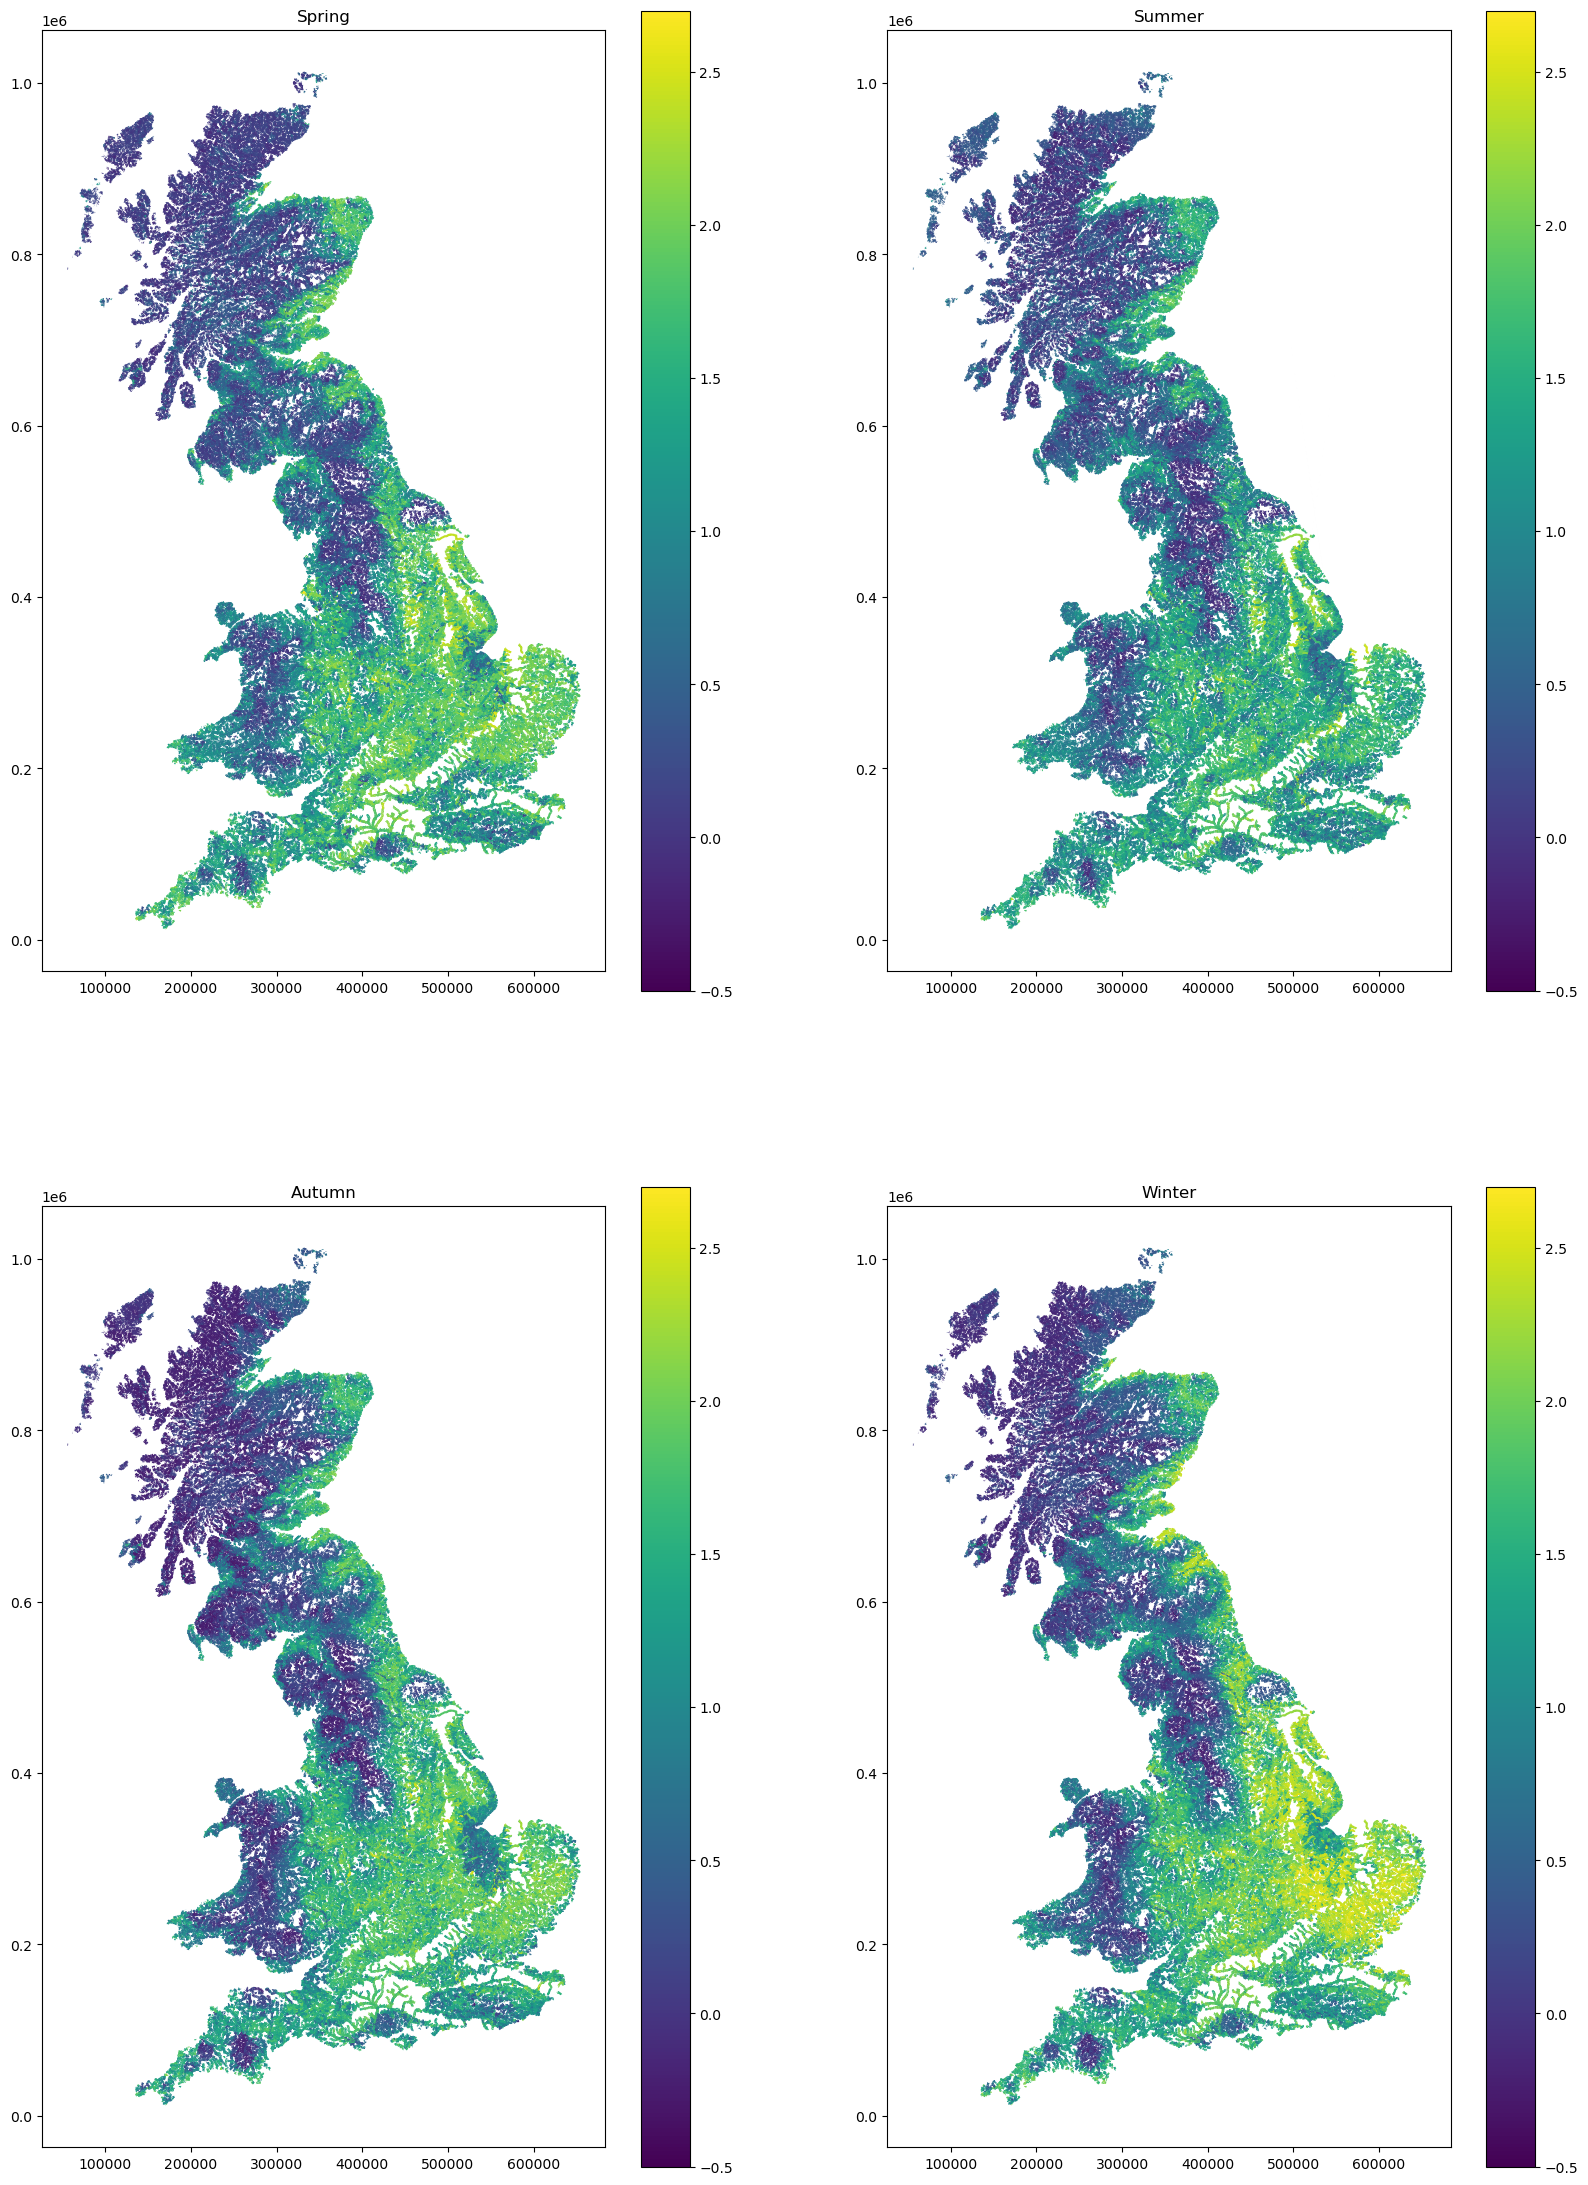

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(20,28))
spring_predicted.plot(column='Predicted_Nitrate', legend=True, ax=ax[0,0], vmax=2.7, vmin=-0.5)
summer_predicted.plot(column='Predicted_Nitrate', legend=True, ax=ax[0,1], vmax=2.7, vmin=-0.5)
autumn_predicted.plot(column='Predicted_Nitrate', legend=True, ax=ax[1,0], vmax=2.7, vmin=-0.5)
winter_predicted.plot(column='Predicted_Nitrate', legend=True, ax=ax[1,1], vmax=2.7, vmin=-0.5)

ax[0,0].set_title('Spring')
ax[0,1].set_title('Summer')
ax[1,0].set_title('Autumn')
ax[1,1].set_title('Winter')

plt.savefig('nitrate_predictions.png')

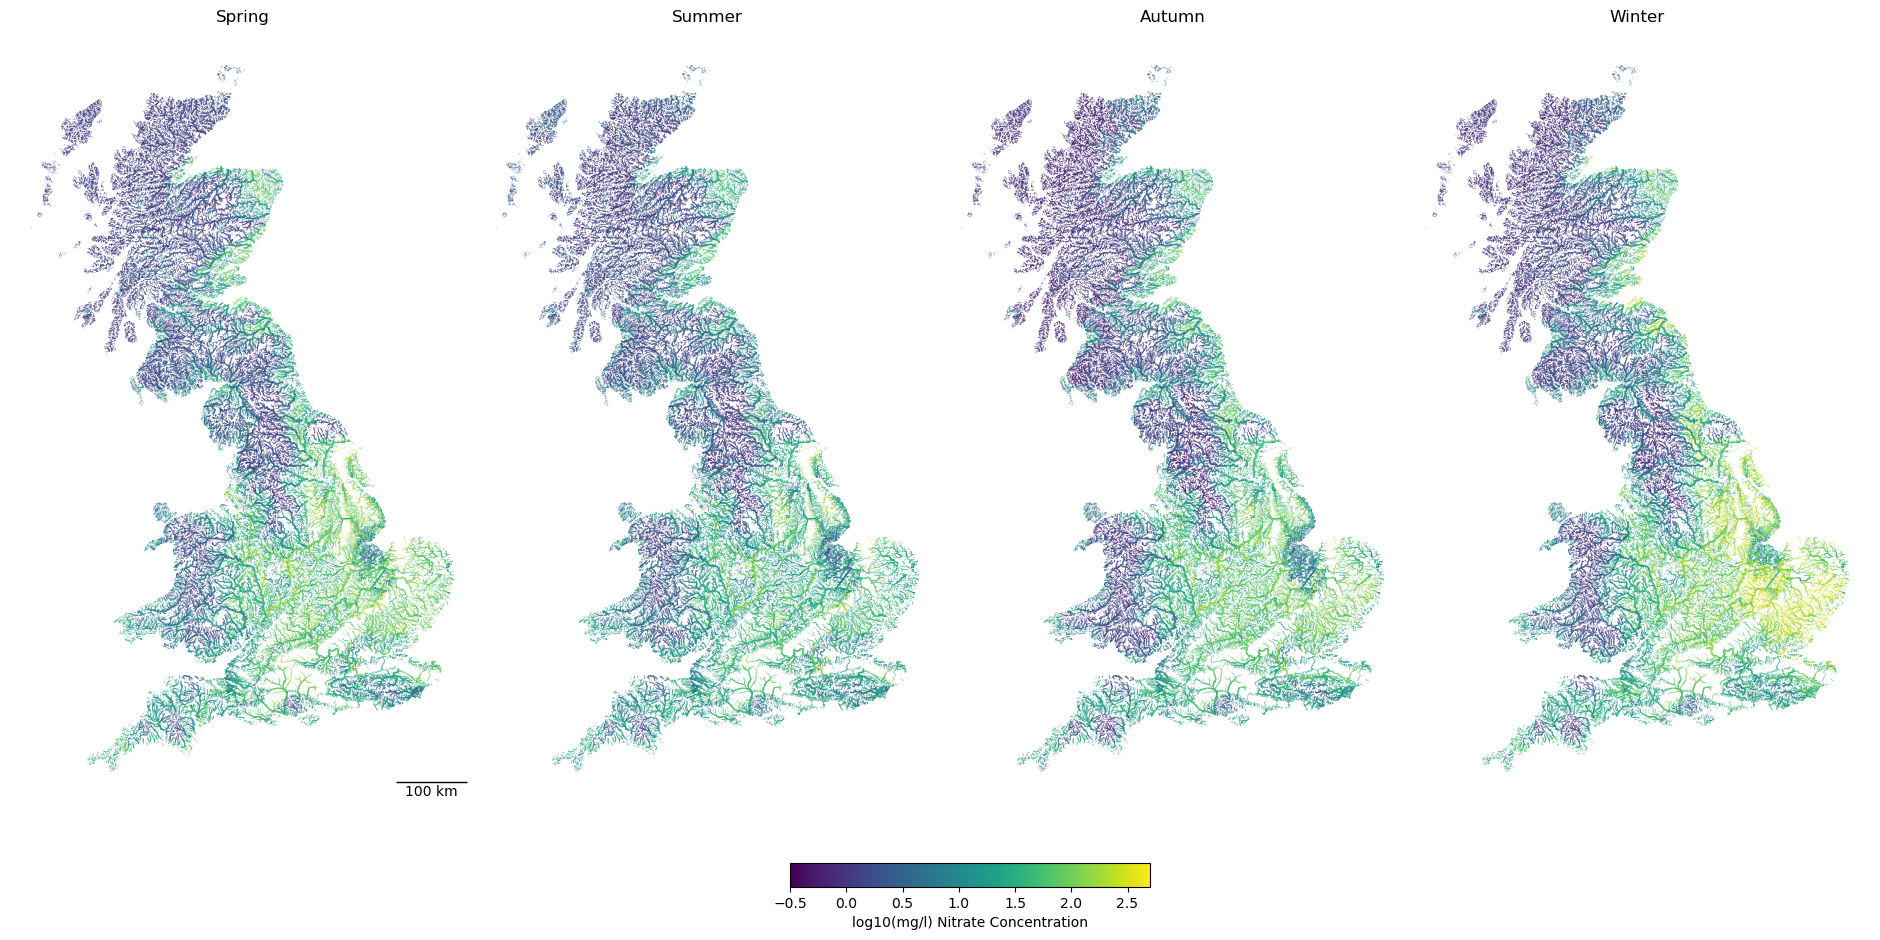

In [39]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib as mpl

fig, ax = plt.subplots(1, 4, figsize=(24,12))
spring_predicted.plot(column='Predicted_Nitrate', ax=ax[0], vmax=2.7, vmin=-0.5, linewidth=spring_predicted['STRAHLER']/6)
summer_predicted.plot(column='Predicted_Nitrate', ax=ax[1], vmax=2.7, vmin=-0.5, linewidth=summer_predicted['STRAHLER']/6)
autumn_predicted.plot(column='Predicted_Nitrate', ax=ax[2], vmax=2.7, vmin=-0.5, linewidth=autumn_predicted['STRAHLER']/6)
winter_predicted.plot(column='Predicted_Nitrate', ax=ax[3], vmax=2.7, vmin=-0.5, linewidth=winter_predicted['STRAHLER']/6)

ax[0].set_title('Spring')
ax[1].set_title('Summer')
ax[2].set_title('Autumn')
ax[3].set_title('Winter')

plt.axis('off')

for i in [0,1,2,3]:
    #for j in [0,1]:
        ax[i].set_axis_off()
        ax[i].set_aspect('equal')

#scale bar
scalebar = AnchoredSizeBar(ax[0].transData,
                           100000, '100 km', 'lower right', 
                           pad=0.5,
                           color='black',
                           frameon=False,
                           size_vertical=1)

ax[0].add_artist(scalebar)

# share colorbars
fig.subplots_adjust(bottom=0.2)
cbar_ax = fig.add_axes([0.45, 0.15, 0.15, 0.02])
norm = mpl.colors.Normalize(vmin=-0.5, vmax=2.7)
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap='viridis',
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('log10(mg/l) Nitrate Concentration')
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('plotting/img/nitrate_predictions2.png',pad_inches=0.0)

In [29]:
print('Test MSE: '+str(MSE(winter_test['Actual'], winter_test['Predicted'])))
print('Train MSE: '+str(MSE(winter_train['Actual'], winter_train['Predicted'])))

print('Test R-Squared: '+str(r2(winter_test['Actual'], winter_test['Predicted'])))
print('Train R-Squared: '+str(r2(winter_train['Actual'], winter_train['Predicted'])))



Test MSE: 0.16626882025417294
Train MSE: 0.03001913035811829
Test R-Squared: 0.6346365261994089
Train R-Squared: 0.9333524613832362


In [30]:
print('Spring R-Squared: '+str(r2(spring_test['Actual'], spring_test['Predicted'])))
print('Summer R-Squared: '+str(r2(summer_test['Actual'], summer_test['Predicted'])))
print('Autumn R-Squared: '+str(r2(autumn_test['Actual'], autumn_test['Predicted'])))
print('Winter R-Squared: '+str(r2(winter_test['Actual'], winter_test['Predicted'])))

Spring R-Squared: 0.5258485257376944
Summer R-Squared: 0.3843430583371208
Autumn R-Squared: 0.48194722314938854
Winter R-Squared: 0.6346365261994089


In [31]:
#save results, https://www.codegrepper.com/code-examples/python/python+pickle+save+and+load+multiple+variables
import pickle
pickle.dump({'spring_train':spring_train, 'summer_train':summer_train, 'autumn_train':autumn_train, 'winter_train':winter_train,\
             'spring_test':spring_test, 'summer_test':summer_test, 'autumn_test':autumn_test, 'winter_test':winter_test,\
             'all_reaches_spring':all_reaches_spring, 'all_reaches_summer':all_reaches_summer, 'all_reaches_autumn':all_reaches_autumn, 'all_reaches_winter':all_reaches_winter,\
             'spring_imps':spring_imps, 'summer_imps':summer_imps, 'autumn_imps':autumn_imps, 'winter_imps':winter_imps,\
             'spring_feats':spring_feats, 'summer_feats':summer_feats, 'autumn_feats':autumn_feats, 'winter_feats':winter_feats,'reaches_no_na':reaches_no_na}, \
            open('results_pkl/nitrate.pkl','wb'))